In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Load the dataset
try:
    df = pd.read_csv('IndianFoodDatasetCSV.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'IndianFoodDatasetCSV.csv' was not found.")
    # Exit if the file is not found
    exit()

Dataset loaded successfully.


In [2]:
# Create an empty bipartite graph
B = nx.Graph()

# Create a dictionary to store the count of each ingredient for each cuisine
cuisine_ingredient_counts = defaultdict(lambda: defaultdict(int))

# Use a set to keep track of unique ingredients to add to the graph later
unique_ingredients = set()

for _, row in df.iterrows():
    cuisine = str(row['Cuisine']).strip().lower()
    
    # Clean and process ingredients, similar to our previous code
    ingredients = [ing.strip().lower() for ing in str(row['TranslatedIngredients']).split(',') if ing.strip() and ing.strip().lower() != 'nan']
    
    cleaned_ingredients = []
    for ing in ingredients:
        # Regex to remove numbers and units
        ing = re.sub(r'(\b\d+(\.\d+)?\s*(cup|teaspoon|tablespoon|tsp|tbsp|grams|g|kg|litre|ml|pinch|dash|clove|slice|pieces)s?\b|\b\d+(\.\d+)?\b)', '', ing, flags=re.I).strip()
        if ing:
            cleaned_ingredients.append(ing)

    # If the cuisine is a valid string, update counts
    if cuisine and cuisine != 'nan':
        for ing in cleaned_ingredients:
            cuisine_ingredient_counts[cuisine][ing] += 1
            unique_ingredients.add(ing)

# Add nodes to the graph
cuisines = list(cuisine_ingredient_counts.keys())
ingredients = list(unique_ingredients)

B.add_nodes_from(cuisines, bipartite=0) # Cuisines are one set
B.add_nodes_from(ingredients, bipartite=1) # Ingredients are the other set

# Add edges with weights
for cuisine, ing_counts in cuisine_ingredient_counts.items():
    for ingredient, count in ing_counts.items():
        if count > 0:
            B.add_edge(cuisine, ingredient, weight=count)
            
print(f"Bipartite graph created with {B.number_of_nodes()} nodes and {B.number_of_edges()} edges.")


Bipartite graph created with 15901 nodes and 32459 edges.


Top 5 ingredients for selected cuisines:

--- Indian ---
- salt - to taste (Used in 523 recipes)
- / turmeric powder (haldi) (Used in 211 recipes)
- red chilli powder (Used in 200 recipes)
- sunflower oil (Used in 184 recipes)
- ghee (Used in 140 recipes)

--- South indian recipes ---
- salt - to taste (Used in 351 recipes)
- sprig curry leaves (Used in 184 recipes)
- sunflower oil (Used in 160 recipes)
- / turmeric powder (haldi) (Used in 157 recipes)
- mustard seeds (Used in 155 recipes)

--- Continental ---
- salt - to taste (Used in 336 recipes)
- extra virgin olive oil (Used in 196 recipes)
- vanilla extract (Used in 167 recipes)
- / salt (Used in 155 recipes)
- lemon juice (Used in 130 recipes)

--- Mexican ---
- salt - to taste (Used in 106 recipes)
- extra virgin olive oil (Used in 37 recipes)
- cumin powder (jeera) (Used in 30 recipes)
- lemon juice (Used in 27 recipes)
- onion - finely chopped (Used in 27 recipes)


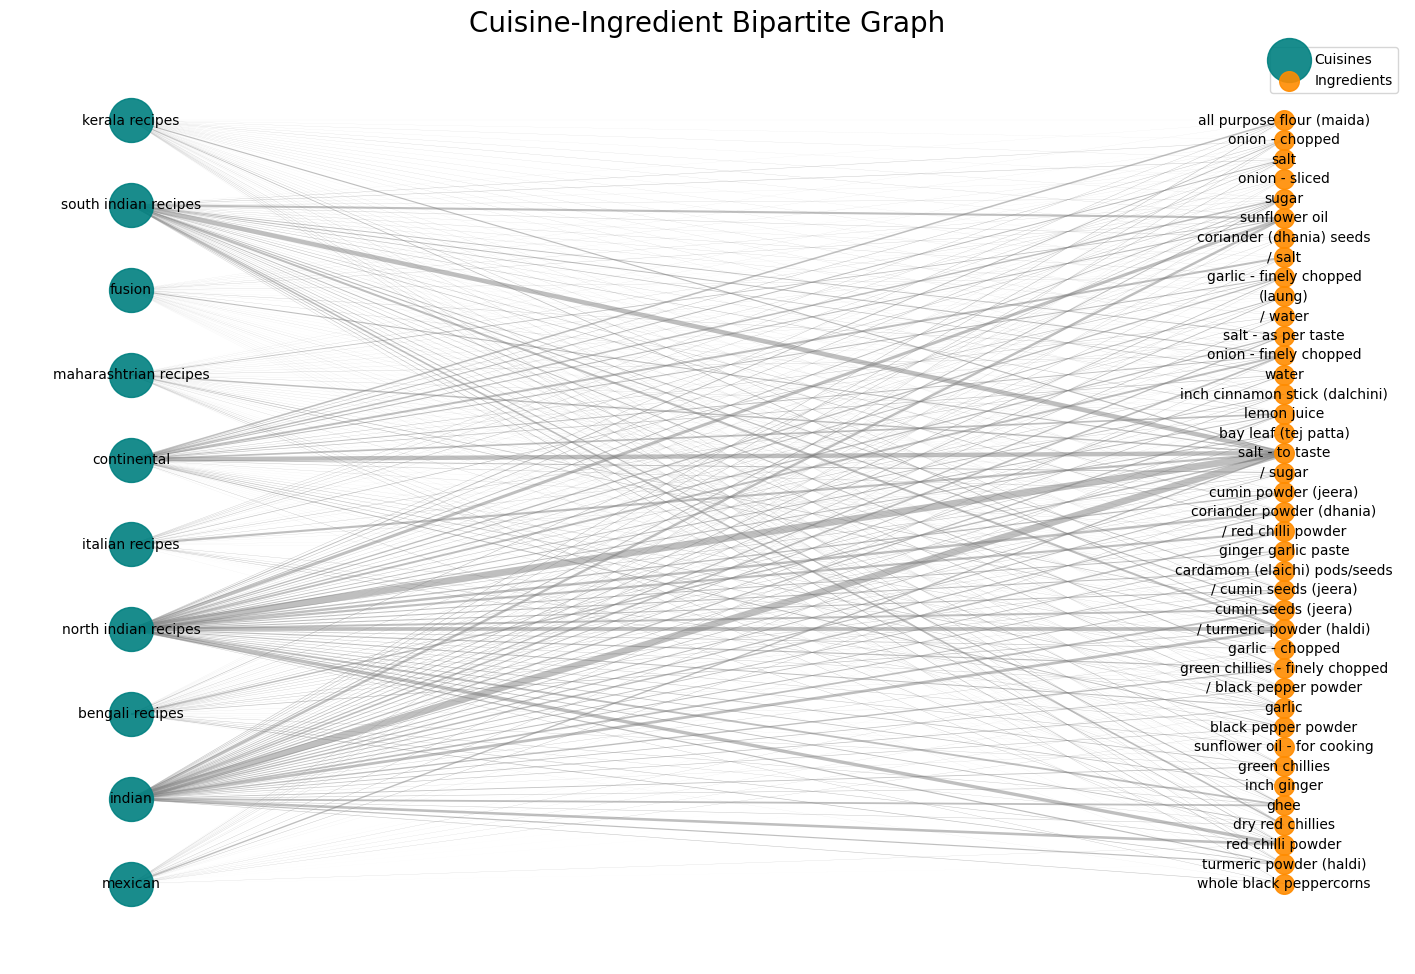

In [5]:
# Find the top ingredients for a specific cuisine
print("Top 5 ingredients for selected cuisines:")
for cuisine in ['indian', 'south indian recipes', 'continental', 'mexican']:
    if cuisine in B.nodes():
        print(f"\n--- {cuisine.capitalize()} ---")
        # Get all neighbors of the cuisine node
        neighbors = B.neighbors(cuisine)
        # Sort neighbors by the edge weight (number of times they appear)
        top_ings = sorted(neighbors, key=lambda x: B.get_edge_data(cuisine, x)['weight'], reverse=True)
        for ing in top_ings[:5]:
            count = B.get_edge_data(cuisine, ing)['weight']
            print(f"- {ing} (Used in {count} recipes)")

# Visualize the bipartite graph
plt.figure(figsize=(18, 12))

# Separate nodes into two sets
top_cuisines = sorted(cuisines, key=lambda x: B.degree(x), reverse=True)[:10]
top_ingredients = sorted(ingredients, key=lambda x: B.degree(x), reverse=True)[:40] # Adjust to show more or less
top_nodes = top_cuisines + top_ingredients

# Create a subgraph of the most connected nodes for clearer visualization
subgraph = B.subgraph(top_nodes)

# Create positions for the nodes
pos = nx.bipartite_layout(subgraph, nodes=top_cuisines)

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=top_cuisines, node_color='teal', node_size=1000, alpha=0.9, label='Cuisines')
nx.draw_networkx_nodes(subgraph, pos, nodelist=top_ingredients, node_color='darkorange', node_size=200, alpha=0.9, label='Ingredients')

# Draw edges, adjusting width based on weight
edge_weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [w / max_weight * 5 for w in edge_weights] 
nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color='gray', alpha=0.5)

# Draw labels
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_family='sans-serif')

plt.legend()
plt.title("Cuisine-Ingredient Bipartite Graph", fontsize=20)
plt.axis('off')
plt.show()

In [6]:
# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(B)

# Find top 10 most connected cuisines
print("Top 10 Most Connected Cuisines:")
top_cuisines = sorted([node for node in B.nodes() if B.nodes[node]['bipartite'] == 0], 
                      key=lambda x: degree_centrality[x], reverse=True)[:10]

for cuisine in top_cuisines:
    print(f"- {cuisine.capitalize()}: {degree_centrality[cuisine]:.4f}")

# Find top 10 most connected ingredients
print("\nTop 10 Most Connected Ingredients:")
top_ingredients = sorted([node for node in B.nodes() if B.nodes[node]['bipartite'] == 1], 
                         key=lambda x: degree_centrality[x], reverse=True)[:10]

for ingredient in top_ingredients:
    print(f"- {ingredient}: {degree_centrality[ingredient]:.4f}")

Top 10 Most Connected Cuisines:
- Indian: 0.2518
- Continental: 0.2273
- North indian recipes: 0.2037
- South indian recipes: 0.1399
- Italian recipes: 0.0750
- Fusion: 0.0601
- Bengali recipes: 0.0586
- Maharashtrian recipes: 0.0560
- Kerala recipes: 0.0492
- Mexican: 0.0448

Top 10 Most Connected Ingredients:
- salt - to taste: 0.0046
- sunflower oil: 0.0040
- / turmeric powder (haldi): 0.0036
- red chilli powder: 0.0036
- onion - finely chopped: 0.0035
- sugar: 0.0033
- lemon juice: 0.0033
- cumin seeds (jeera): 0.0033
- garlic: 0.0033
- garlic - finely chopped: 0.0032


In [7]:
# Project the bipartite graph onto the cuisine nodes
cuisine_graph = nx.bipartite.weighted_projected_graph(B, cuisines)

print("\nCuisine-Cuisine Graph created.")
print(f"Nodes: {cuisine_graph.number_of_nodes()}, Edges: {cuisine_graph.number_of_edges()}")

# You can now analyze or visualize this new graph. For example, let's find the most similar cuisines.
print("\nTop 5 Most Similar Cuisine Pairs:")
top_cuisine_pairs = sorted(cuisine_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
for u, v, d in top_cuisine_pairs:
    print(f"- {u.capitalize()} and {v.capitalize()}: {d['weight']} shared ingredients")

# Project the bipartite graph onto the ingredient nodes
ingredient_graph = nx.bipartite.weighted_projected_graph(B, ingredients)

print("\nIngredient-Ingredient Graph created.")
print(f"Nodes: {ingredient_graph.number_of_nodes()}, Edges: {ingredient_graph.number_of_edges()}")
# You can now find the most commonly co-occurring ingredients based on their co-occurrence across cuisines.
print("\nTop 5 Most Common Ingredient Pairs:")
top_ingredient_pairs = sorted(ingredient_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
for u, v, d in top_ingredient_pairs:
    print(f"- {u} and {v}: used together in {d['weight']} cuisines")


Cuisine-Cuisine Graph created.
Nodes: 82, Edges: 3147

Top 5 Most Similar Cuisine Pairs:
- Indian and North indian recipes: 1194 shared ingredients
- Indian and South indian recipes: 833 shared ingredients
- Indian and Continental: 813 shared ingredients
- South indian recipes and North indian recipes: 781 shared ingredients
- Continental and North indian recipes: 620 shared ingredients

Ingredient-Ingredient Graph created.
Nodes: 15819, Edges: 23832852

Top 5 Most Common Ingredient Pairs:
- sunflower oil and salt - to taste: used together in 62 cuisines
- salt - to taste and red chilli powder: used together in 57 cuisines
- salt - to taste and / turmeric powder (haldi): used together in 56 cuisines
- salt - to taste and onion - finely chopped: used together in 54 cuisines
- sunflower oil and / turmeric powder (haldi): used together in 53 cuisines
